In [213]:
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from formulaic import model_matrix
from sklearn.datasets import load_wine
from sklearn.model_selection import GridSearchCV
import logging
import re


In [214]:
wine = load_wine(as_frame=True)
dir(wine)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [215]:
wine.data.columns = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od315_of_diluted_wines', 'proline']

In [260]:
X = wine.data[wine.data.columns[1::]]
y = wine.data["alcohol"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

## MODELO 1

In [261]:
formula = '~ malic_acid + ash + alcalinity_of_ash + magnesium + total_phenols + flavanoids + nonflavanoid_phenols + proanthocyanins + color_intensity + od315_of_diluted_wines + hue + proline'
X_train1 = model_matrix(formula, data=X_train)
X_test1 = model_matrix(formula, data=X_test)

In [262]:
alphas = np.logspace(-4,4,100)
alpha = {"alpha": alphas}

In [263]:
gs = GridSearchCV(
    Ridge(),
    alpha,
    cv=5,
    scoring = "neg_root_mean_squared_error",
    return_train_score=True,
)

gs.fit(X_train1, y_train)

gs.best_params_, gs.best_index_, gs.best_score_

({'alpha': 54.62277217684348}, 71, -0.551575069701401)

In [264]:
cv_results_ = pd.DataFrame(gs.cv_results_)[["param_alpha", "mean_test_score", "mean_train_score"]]
cv_results_[["mean_test_score", "mean_train_score"]] *= -1


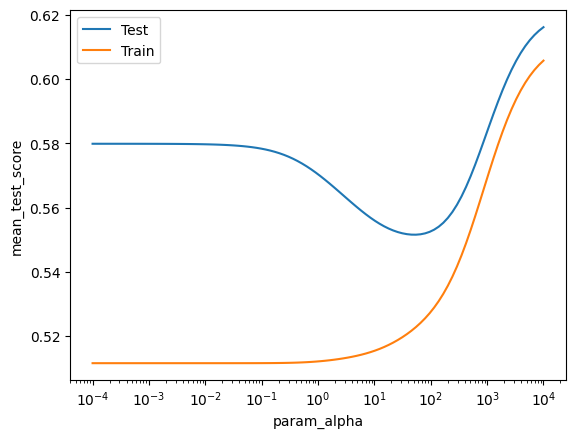

In [265]:
sns.lineplot(x="param_alpha", y="mean_test_score", data=cv_results_, label="Test")
sns.lineplot(x="param_alpha", y="mean_train_score", data=cv_results_, label="Train")
plt.xscale("log")
plt.show()

In [266]:
y_pred = gs.predict(X_test1)
recm = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test: {recm}\nTrain: {(-1)*gs.best_score_}")

Test: 0.5263334489798448
Train: 0.551575069701401


In [267]:
wine2 = X_test1.copy()
wine2["alcohol"] = y_test
wine2["prediccion"] = y_pred 
wine2["residuos"] = wine2["alcohol"] - wine2["prediccion"]
wine2.shape
wine2.shape

(36, 16)

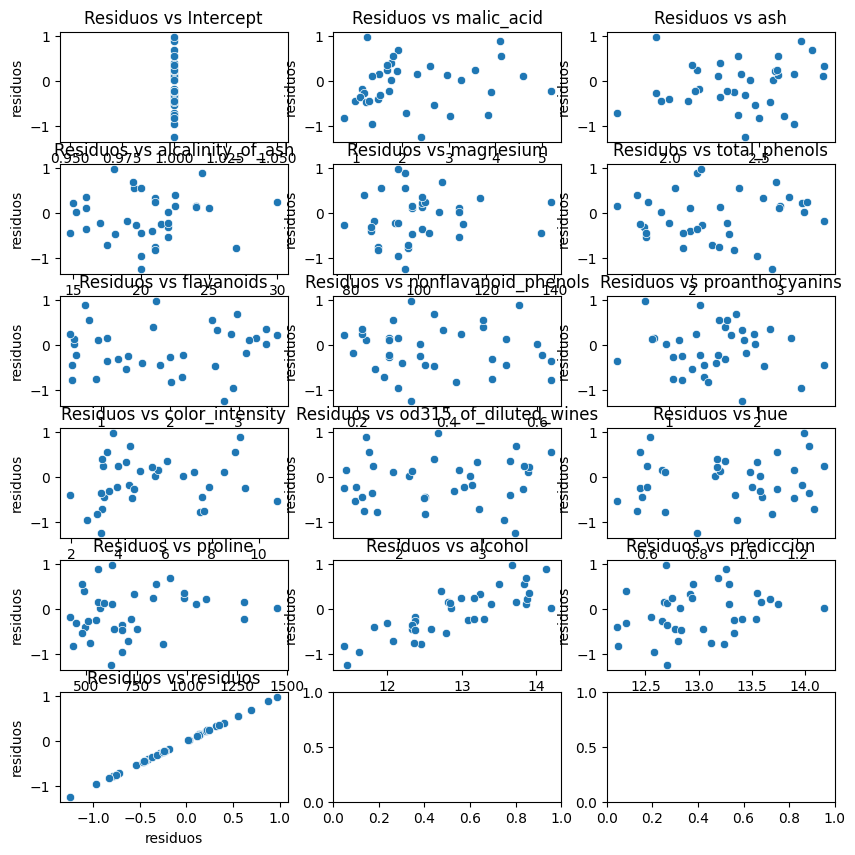

In [270]:
fig, axs= plt.subplots(6, 3, figsize = (10, 10))
for versus, ax in zip(wine2.columns, axs.flatten()):
    sns.scatterplot(x=versus, y="residuos", data=wine2, ax=ax).set_label(None)
    ax.set_title(f"Residuos vs {versus}")

In [269]:
m_al = wine.data["alcohol"].mean()
m_res = wine2["prediccion"].mean()
print(f"Diferencial proporcional de media de predicciones respecto de alcohol: {m_res/m_al*100}%")

Diferencial proporcional de media de predicciones respecto de alcohol: 99.98112586668543%


Los residuos parecen no tener estructura por sobre ningun dato respecto del modelo, las predicciones tienen un porcentaje de similitud a los datos de practicamente 100% (respecto de los datos totales) y la raiz del error cuadratico medio es de 0.5 para los datos de test. Por lo tanto tiene sentido decir que este modelo es todo un exito.